In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
import itertools

In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
from choice_learn.models.base_model import ChoiceModel
from choice_learn.data import ChoiceDataset

2026-01-01 11:09:43.226943: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-01-01 11:09:43.227163: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-01-01 11:09:43.287428: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-01-01 11:09:43.478056: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-01 11:09:44.911466: W tensorflow/compiler/tf2

In [3]:
# Set device
if tf.config.list_physical_devices('GPU'):
    device = '/GPU:0'
    print(f"Use GPU: {tf.config.list_physical_devices('GPU')[0]}")
else:
    device = '/CPU:0'
    print("Use CPU")

Use GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [4]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
project_root = os.path.abspath(os.getcwd())
sys.path.insert(0, project_root)

print(project_root)

/root/Q3/DeepHalo-tf/Final/DeepHalo


In [6]:
from DeepHalo import DeepHaloChoiceModel

Initializing DeepHaloChoiceModel package v1.0.0


# Train

In [7]:
def build_model(H, depth, embed, featureless=True, feature2D=False, epochs=20, batch_size=64, loss_name='nll', **kwargs):
    # build a DeepHalo choice model with the given specifications
    
    DeepHalo_model = DeepHaloChoiceModel(
    H=H,
    depth=depth,
    embed=embed,
    featureless=featureless,
    feature2D=feature2D,
    epochs=epochs,
    batch_size=batch_size,
    loss_name=loss_name,
    )
    
    return DeepHalo_model


In [8]:
def create_choice_dataset(file_load_path, J, S, N_train=40, N_test=10):
    # Create ChoiceDataset for choice_learn

    train_file_path = os.path.join(file_load_path, f'Synthetic_{J}-{S}-{N_train}_Train.csv')
    test_file_path = os.path.join(file_load_path, f'Synthetic_{J}-{S}-{N_test}_Test.csv')


    df_train = pd.read_csv(train_file_path)
    df_test = pd.read_csv(test_file_path)


    Y_cols = [f"Y{i}" for i in range(J)]
    Y_array = df_train[Y_cols].to_numpy()        # [N_choices, J]
    
    X_cols = [f"X{i}" for i in range(J)]
    avail = df_train[X_cols].to_numpy()          # [N_choices, J]
    choices = np.argmax(Y_array, axis=1)         # [N_choices]

    
    # Create one-hot encoded data matrix for featureless setting
    X_array = np.tile(np.eye(J)[None, ...], [avail.shape[0], 1, 1])
    
    dataset = ChoiceDataset(
    items_features_by_choice=X_array,
    choices=choices,
    available_items_by_choice=avail,
    items_features_by_choice_names=[f"f{k}" for k in range(J)])

    return dataset

In [9]:
def count_net_params(dataset, budget, embed, featureless=True, feature2D=False, H_min=2, H_max=100, depth_min=3, depth_max=8, **kwargs):
    # function to specify the (depth, H) configuration for the network that matches the given budget

    avail = dataset.available_items_by_choice.astype(np.float32)[:2]
    X_items = dataset.items_features_by_choice[0].astype(np.float32)[:2]


    candidates = []

    H = H_max + 1
    for depth in range(depth_min, depth_max):
        min_diff = 1e9
        while H>= H_min:            
            DeepHalo_model = build_model(H, depth, embed, featureless, feature2D)
            _ = DeepHalo_model.deep_halo_core(X_items, avail, training=False)
            p = DeepHalo_model.deep_halo_core.count_params()
            diff = abs(p-budget)
            if diff <= min_diff:
                min_diff = diff
                p_saved = p
                H_saved = H
            else: 
                p = p_saved
                H = H_saved
                candidates.append((depth, H, p))
                break
            
            H -= 1
        
    return candidates
    

In [10]:
def get_configs(dataset, budgets, embed, featureless=True, feature2D=False, H_min=2, H_inf=10000, depth_min=3, depth_max=8, **kwargs):
    # function to return a configs dictionary for all given budgets 

    J = dataset.base_num_items
    configs_dict = {} 
    for budget in Budgets:
        key = f"{int(budget/1000)}k" 
        if featureless:
            H_max = int(H_inf/J)
        else:
            H_max = int(H_inf/(J*embed))
        configs = count_net_params(dataset, budget, embed, featureless, feature2D, H_min, H_max, depth_min, depth_max)
        configs_dict[key] = [config[:2] for config in configs]

    return configs_dict

In [11]:
def train_deephalo_synthetic(dataset, budget, H, depth, embed, featureless, 
                             feature2D, epochs, batch_size, loss_name, 
                             J, S, save_path, **kwargs ):

    
    # function to train DeepHalo method for different experiments for different J, budget, etc.
    
    avail = dataset.available_items_by_choice.astype(np.float32)
    X_items = dataset.items_features_by_choice[0].astype(np.float32)      # [N, J, D0]  (D0=J)
       

    DeepHalo_model = build_model(H, depth, embed, featureless, feature2D, epochs, batch_size, loss_name)
    _ = DeepHalo_model.deep_halo_core(X_items[:2], avail[:2], training=False)

    history = DeepHalo_model.fit(dataset)



    
    # Save weights
    DeepHalo_model.deep_halo_core.save_weights(
        os.path.join(file_save_path, f'Bud{budget}-Depth-{depth}-H-{H}-epoch{epochs}-Fless{featureless}-2D{feature2D}-{loss_name}-embed{embed}-J{J}-S{S}syn.weights.h5')
    )
    
    # Save training history as numpy file
    np.save(
        os.path.join(file_save_path, f'Bud{budget}-Depth-{depth}-H-{H}-epoch{epochs}-Fless{featureless}-2D{feature2D}-{loss_name}-embed{embed}-J{J}-S{S}syn-hist.npy'),
        history
    )

In [12]:
J = 12
S = 4
file_load_path = os.path.join(project_root, 'Data')
dataset = create_choice_dataset(file_load_path, J, S)

In [13]:
Budgets = [200000, 500000]

embed = J
featureless = True
feature2D = False
if featureless:
    embed = J
configs_dict = get_configs(dataset, Budgets, embed, featureless, feature2D, H_min=2, H_inf=15000, depth_min=1, depth_max=6)
configs_dict


2026-01-01 11:09:48.151819: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2026-01-01 11:09:48.151940: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2026-01-01 11:09:48.151999: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2026-01-01 11:09:48.423409: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2026-01-01 11:09:48.423600: I external/local_xla/xla/stream_executor

{'200k': [(1, 1183), (2, 592), (3, 394), (4, 296), (5, 237)],
 '500k': [(1, 1251), (2, 1251), (3, 986), (4, 740), (5, 592)]}

In [14]:
# J = 12
# depth = 5
# H = 237
# embed = J
# featureless = True
# feature2D = False

# avail = tf.ones((1, J))
# X_array = tf.tile(tf.eye(J)[None, ...], [avail.shape[0], 1, 1])

        
# DeepHalo_model = build_model(H, depth, embed, featureless, feature2D)
# _ = DeepHalo_model.deep_halo_core(X_array, avail, training=False)


# print(DeepHalo_model.deep_halo_core.count_params())
# # DeepHalo_model.deep_halo_core.summary()

In [15]:
file_load_path = os.path.join(project_root, 'Data')

# Save path
file_save_path = os.path.join(project_root, 'Experiments', 'Synthetic')
os.makedirs(file_save_path, exist_ok=True)

epochs = 500
batch_size = 64  # Reduced batch size to help with memory
lr = 0.001

# J_S_pairs = [(18, 15), (12, 8), (19, 16), (34,32)]
J_S_pairs = [(12, 4)]

Budgets = [200000, 500000]


# Implement the corrected permutation equivariant featureless model with 3D features  
featureless = True   
feature2D = False  
loss_name = 'nll'


configs_dict_list = []


for J, S in J_S_pairs:
    print(f'=== Testing (J,S) Pair: ({J},{S}) ===')

    dataset = create_choice_dataset(file_load_path, J, S)

    if featureless:
        embed = J
    else:
        embed = 16

    if S<=4:        
        configs_dict = get_configs(dataset, Budgets, embed, featureless, feature2D, H_min=2, H_inf=15000, depth_min=1, depth_max=6)
    else:
        configs_dict = get_configs(dataset, Budgets, embed, featureless, feature2D, H_min=2, H_inf=15000)

    configs_dict_list.append(configs_dict)
    for budget, depth_H in configs_dict.items():
        
        print(f'=== Testing Budget Group: {budget} ===')
        for depth, H in depth_H:
            print(f'Depth: {depth}, H: {H}')
            
            train_deephalo_synthetic(dataset, budget, H, depth, embed, featureless, feature2D, epochs, batch_size, loss_name, J, S, file_save_path )



=== Testing (J,S) Pair: (12,4) ===
=== Testing Budget Group: 200k ===
Depth: 1, H: 1183


  0%|                                                                                           | 0/500 [00:00<?, ?it/s]2026-01-01 11:12:32.621196: I external/local_xla/xla/service/service.cc:168] XLA service 0x73b232e4ef10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2026-01-01 11:12:32.621267: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2026-01-01 11:12:32.652751: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-01-01 11:12:32.709591: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
I0000 00:00:1767226352.806102   19990 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
Epoch 499 Train Loss 1.3530: 100%|███████████████████████████████

Depth: 2, H: 592


Epoch 499 Train Loss 1.0949: 100%|████████████████████████████████████████████████████| 500/500 [26:14<00:00,  3.15s/it]


Depth: 3, H: 394


Epoch 499 Train Loss 1.0684: 100%|████████████████████████████████████████████████████| 500/500 [27:12<00:00,  3.27s/it]


Depth: 4, H: 296


Epoch 499 Train Loss 1.0579: 100%|████████████████████████████████████████████████████| 500/500 [29:18<00:00,  3.52s/it]


Depth: 5, H: 237


Epoch 499 Train Loss 1.0564: 100%|████████████████████████████████████████████████████| 500/500 [30:43<00:00,  3.69s/it]


=== Testing Budget Group: 500k ===
Depth: 1, H: 1251


Epoch 499 Train Loss 1.3530: 100%|████████████████████████████████████████████████████| 500/500 [26:58<00:00,  3.24s/it]


Depth: 2, H: 1251


Epoch 499 Train Loss 1.0840: 100%|████████████████████████████████████████████████████| 500/500 [48:46<00:00,  5.85s/it]


Depth: 3, H: 986


Epoch 499 Train Loss 1.0656: 100%|████████████████████████████████████████████████████| 500/500 [56:59<00:00,  6.84s/it]


Depth: 4, H: 740


Epoch 499 Train Loss 1.0579: 100%|████████████████████████████████████████████████████| 500/500 [57:49<00:00,  6.94s/it]


Depth: 5, H: 592


Epoch 499 Train Loss 1.0571: 100%|████████████████████████████████████████████████████| 500/500 [58:37<00:00,  7.04s/it]


<Figure size 1000x600 with 0 Axes>

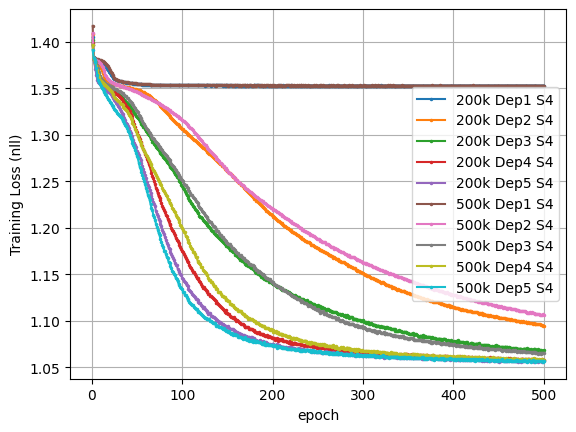

In [16]:
# Define the file path
file_save_path = os.path.join(project_root, 'Experiments', 'Synthetic')

# epochs = 500
# batch_size = 64  # Reduced batch size to help with memory
# lr = 0.001

# # J_S_pairs = [(18, 15), (12, 8), (19, 16), (34,32)]
# J_S_pairs = [(12, 4)]

# Budgets = [200000, 500000]

# featureless = True
# feature2D = False
# loss_name = 'nll'



loss_dict = {}
cnt = -1

for J, S in J_S_pairs:
    cnt += 1
    if featureless:
        embed = J
    else:
        embed = 16

    
    configs_dict = configs_dict_list[cnt]
    
    for budget, depth_H in configs_dict.items():
        for depth, H in depth_H:
            filename = os.path.join(file_save_path, f'Bud{budget}-Depth-{depth}-H-{H}-epoch{epochs}-Fless{featureless}-2D{feature2D}-{loss_name}-embed{embed}-J{J}-S{S}syn-hist.npy')
    
            # Load the model info
            history = np.load(filename, allow_pickle=True).item()
    
            key = f"{budget} Dep{depth} S{S}"
            train_loss_tensors = history['train_loss']
            train_losses = [float(l) for l in train_loss_tensors]
            loss_dict[key] = train_losses

df = pd.DataFrame(loss_dict)
df.index = range(1, len(df) + 1)

plt.figure(figsize=(10, 6))
ax = df.plot(kind='line', linewidth=1.5, marker=".", markersize=3)
ax.set_xlabel("epoch")
# ax.set_yscale('log')
ax.set_ylabel(f"Training Loss ({loss_name})")
plt.grid(True)
plt.savefig(os.path.join(file_save_path, f'plot-epoch{epochs}-Fless{featureless}-2D{feature2D}-{loss_name}-embed{embed}-S{S}-J{J}-syn.pdf'), format='pdf', bbox_inches='tight')
plt.show()

<Figure size 1000x600 with 0 Axes>

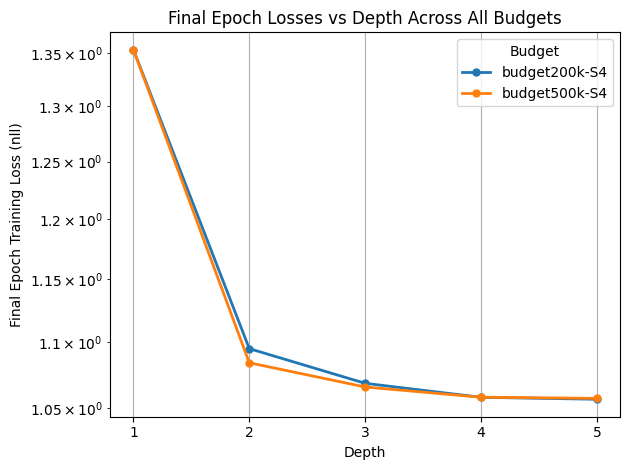

In [17]:
# Extract all unique depths across all experiments
all_depths = set()
final_losses = {}

cnt = -1
for J, S in J_S_pairs:
    cnt += 1
    if featureless:
        embed = J
    else:
        embed = 16

    configs_dict = configs_dict_list[cnt]
    
    for budget, depth_H in configs_dict.items():
        for depth, H in depth_H:
            key = f"{budget} Dep{depth} S{S}"
            if key in loss_dict:  # Only if data exists
                all_depths.add(depth)
                if S not in final_losses:
                    final_losses[S] = {}
                if budget not in final_losses[S]:
                    final_losses[S][budget] = {}
                final_losses[S][budget][depth] = loss_dict[key][-1]


# Create sorted depths and DataFrame
depths = sorted(all_depths)[::-1]
df_data = {}
for S in final_losses:
    for budget in final_losses[S]:
        df_data[f"budget{budget}-S{S}"] = [final_losses[S][budget].get(depth) for depth in depths]

df = pd.DataFrame(df_data, index=depths)

# Line plot for all budgets
plt.figure(figsize=(10, 6))
ax = df.plot(kind='line', marker='o', linewidth=2, markersize=5)
plt.xlabel('Depth')
plt.ylabel(f'Final Epoch Training Loss ({loss_name})')
plt.title('Final Epoch Losses vs Depth Across All Budgets')
plt.legend(title='Budget', loc='upper right')

plt.xticks(depths)
plt.grid(True)

plt.yscale('log')
plt.tight_layout()
plt.savefig(os.path.join(file_save_path, f'plot-epoch{epochs}-Fless{featureless}-2D{feature2D}-{loss_name}-embed{embed}-S{S}-J{J}-syn_final.pdf'), format='pdf', bbox_inches='tight')
plt.show()